# Earthquake Detection Model #
The purpose of this project is to create a model that will predict the power of earthquakes.  The dataset comes from the National Earthquake Information Center (NEIC).  NEIC identifies the location and scale of all major worldwide earthquakes. 

First, the dataset will be explored to understand what information is provided before going into cleaning the data.  After that, some feature engineering will be conducted before training the model.

The neural network in the model will be created by levarging Keras.  This is because it will be easiest to try different combinations of hyperparameters to create the best model.  

Lastly, the best model will be used on the testing data in order to see how well it performs on the testing data.  

## Data Inspection and Cleaning ##


In [14]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [15]:
# bring in data
data = pd.read_csv('/kaggle/input/earthquakes/database.csv')

# look through data
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 21 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Date                        23412 non-null  object 
 1   Time                        23412 non-null  object 
 2   Latitude                    23412 non-null  float64
 3   Longitude                   23412 non-null  float64
 4   Type                        23412 non-null  object 
 5   Depth                       23412 non-null  float64
 6   Depth Error                 4461 non-null   float64
 7   Depth Seismic Stations      7097 non-null   float64
 8   Magnitude                   23412 non-null  float64
 9   Magnitude Type              23409 non-null  object 
 10  Magnitude Error             327 non-null    float64
 11  Magnitude Seismic Stations  2564 non-null   float64
 12  Azimuthal Gap               7299 non-null   float64
 13  Horizontal Distance         160

Looking at the data, there are some columns that have incomplete data.  Those columns aren't going to be much use, so this dataset will have 23,412 datapoints.  Any column that does not have enough datapoints will be dropped since they can't help.

In [16]:
# drop columns that lack enough datapoints
threshold = 23412
data = data.dropna(axis = 1, thresh = threshold)

print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23412 entries, 0 to 23411
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Date              23412 non-null  object 
 1   Time              23412 non-null  object 
 2   Latitude          23412 non-null  float64
 3   Longitude         23412 non-null  float64
 4   Type              23412 non-null  object 
 5   Depth             23412 non-null  float64
 6   Magnitude         23412 non-null  float64
 7   ID                23412 non-null  object 
 8   Source            23412 non-null  object 
 9   Location Source   23412 non-null  object 
 10  Magnitude Source  23412 non-null  object 
 11  Status            23412 non-null  object 
dtypes: float64(4), object(8)
memory usage: 2.1+ MB
None


In [17]:
print(data.head())

         Date      Time  Latitude  Longitude        Type  Depth  Magnitude  \
0  01/02/1965  13:44:18    19.246    145.616  Earthquake  131.6        6.0   
1  01/04/1965  11:29:49     1.863    127.352  Earthquake   80.0        5.8   
2  01/05/1965  18:05:58   -20.579   -173.972  Earthquake   20.0        6.2   
3  01/08/1965  18:49:43   -59.076    -23.557  Earthquake   15.0        5.8   
4  01/09/1965  13:32:50    11.938    126.427  Earthquake   15.0        5.8   

             ID  Source Location Source Magnitude Source     Status  
0  ISCGEM860706  ISCGEM          ISCGEM           ISCGEM  Automatic  
1  ISCGEM860737  ISCGEM          ISCGEM           ISCGEM  Automatic  
2  ISCGEM860762  ISCGEM          ISCGEM           ISCGEM  Automatic  
3  ISCGEM860856  ISCGEM          ISCGEM           ISCGEM  Automatic  
4  ISCGEM860890  ISCGEM          ISCGEM           ISCGEM  Automatic  


Let's explore the 'Type' column to understand what else is listed in the dataset potentially, besides earthquakes.  

In [18]:
unique_types = data['Type'].unique()
print(unique_types)

['Earthquake' 'Nuclear Explosion' 'Explosion' 'Rock Burst']


Interestingly, there are some labels that indicate if something that was detected was not an earthquake.  So, let's see how many of these values there really are to see if the noise is worth keeping in the dataset.  

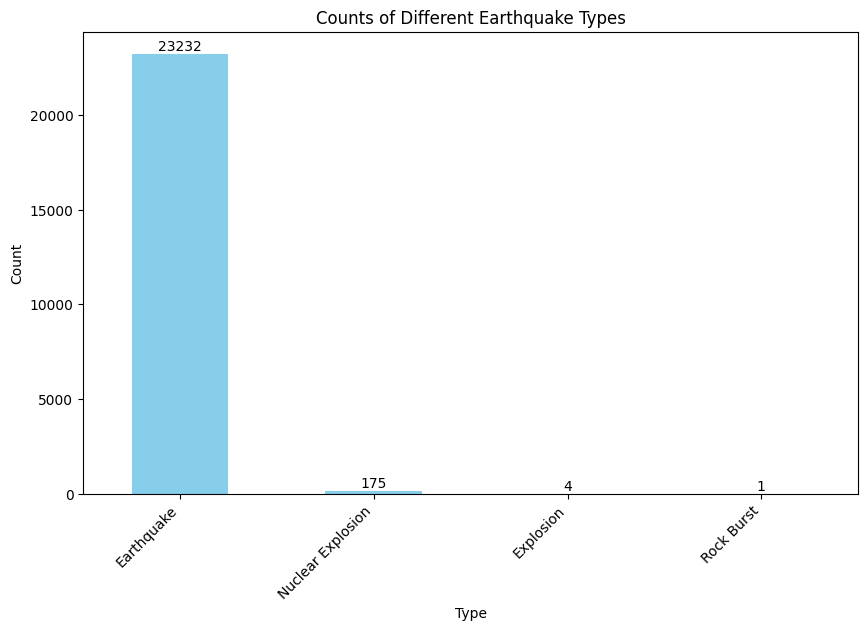

In [19]:
type_counts = data['Type'].value_counts()

# create plot
plt.figure(figsize=(10,6))
bars = type_counts.plot(kind = 'bar', color = 'skyblue')
plt.title('Counts of Different Earthquake Types')
plt.xlabel('Type')
plt.ylabel('Count')
plt.xticks(rotation=45, ha = 'right')


for bar in bars.patches:
    plt.annotate(format(bar.get_height(), '.0f'),
                (bar.get_x() + bar.get_width() / 2, bar.get_height()),
                ha = 'center', va = 'center',
                xytext=(0,5),
                textcoords = 'offset points')
    
    
plt.show()

This project is concerned with creating a model to predict an earthquakes overall magnitude and depth, not if an earthquake happened or not.  So, as a result these non-earthquake types are not worth keeping in the dataset.  This was worth exploring though because maybe a different model could be made with a different dataset trying to predict if something was an earthquake or not.  More data would be needed for that though because this clearly is not.  

Based on looking through the dataset, only a few of the columns are worth keeping:  
* Longitude & Latitude are worth keeping because we want to be able to understand how the location of an earthquake occured affects the power of the earthquake 
* Depth & Magnitude are because that's eventually what we are going to be predicting
* Date & Time are going to be kept so we can understand historical context.  When you are thinking about geologic timescales, when a major earthquake happened could tell you a lot about what else may have been going on with earth at that time.  

In [20]:
data = data[['Date', 'Time', 'Latitude', 'Longitude', 'Depth', 'Magnitude']]

NameError: name 'cartopy' is not defined

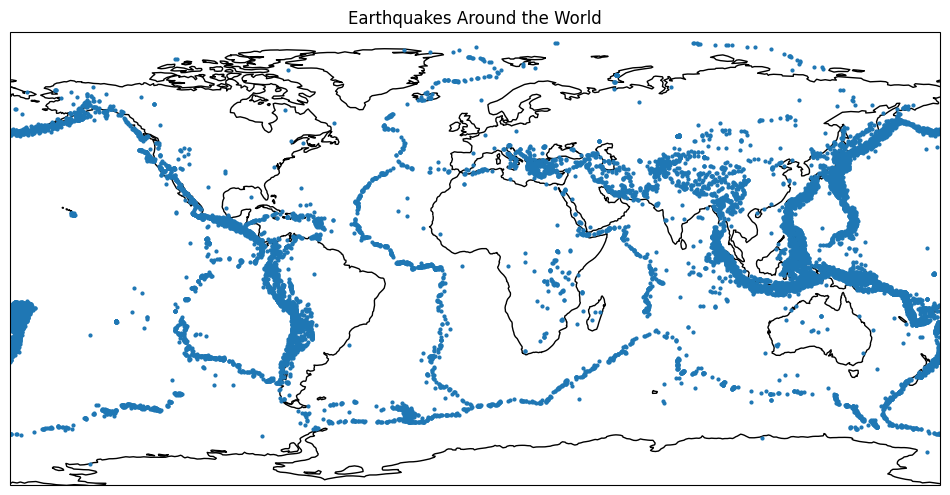

In [21]:
# visualize the earthquakes
import cartopy.crs as ccrs

# Create a Cartopy projection
projection = ccrs.PlateCarree()

# Extract longitudes and latitudes from the DataFrame
longitudes = data["Longitude"].tolist()
latitudes = data["Latitude"].tolist()

# Create a figure and axes with the specified projection
fig, ax = plt.subplots(figsize=(12, 10), subplot_kw=dict(projection=projection))
ax.set_title("Earthquakes Around the World")

# Plot data
for i in range(len(longitudes)):
    ax.plot(longitudes[i], latitudes[i], 'o', markersize=2, color='#1f77b4', transform=projection)

# Add map features
ax.coastlines()
ax.add_feature(cartopy.feature.LAND, color='lightgray')
ax.add_feature(cartopy.feature.OCEAN, color='#00FFFF')  # Using the color you specified

# Show the plot
plt.show()

## Feature Engineering ##
In order to make all the columns the same datatype there needs to be some feature engineering done on this dataset.  "Date" and "Time" are both listed as objects and unfortunatley are not listed in an ideal format for what we need.

When an earthquake happened can tell an important story about what else was going on with earth at that time.  Plus, as you can tell from the map a lot of earthquakes happened in the same spot.  So having the date and time is the only way to distinguish.  

Fortunatley, pandas has a powerful tool to convert to the date and time into a timestamp using "datetime"

In [22]:
# combine date and time into one column
data['Timestamp'] = pd.to_datetime(data['Date'] + ' ' + data['Time'], format = '%m/%d/%Y %H:%M:%S', errors = 'coerce')

data.drop(['Date', 'Time'], axis = 1, inplace = True)
data_final = data.dropna(subset = ['Timestamp'])

# Convert Timestamp to Unix timestamps (float64)
data_final['Timestamp'] = data_final['Timestamp'].astype('int64') / 10**9


print(data_final.head())
print(data_final.info())

   Latitude  Longitude  Depth  Magnitude    Timestamp
0    19.246    145.616  131.6        6.0 -157630542.0
1     1.863    127.352   80.0        5.8 -157465811.0
2   -20.579   -173.972   20.0        6.2 -157355642.0
3   -59.076    -23.557   15.0        5.8 -157093817.0
4    11.938    126.427   15.0        5.8 -157026430.0
<class 'pandas.core.frame.DataFrame'>
Index: 23409 entries, 0 to 23411
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Latitude   23409 non-null  float64
 1   Longitude  23409 non-null  float64
 2   Depth      23409 non-null  float64
 3   Magnitude  23409 non-null  float64
 4   Timestamp  23409 non-null  float64
dtypes: float64(5)
memory usage: 1.1 MB
None


/tmp/ipykernel_34/1472523422.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_final['Timestamp'] = data_final['Timestamp'].astype('int64') / 10**9


## Dataset Split ##
As stated previously, the goal is to create a model that will be accurate at determining the power (magnitude and depth) of earthquakes given the location and time that an earthquake occured. 

As in most machine learning, the train and test sets will be split 80/20.  

In [23]:
from sklearn.model_selection import train_test_split
X = data_final[['Timestamp', 'Latitude', 'Longitude']]
y = data_final[['Magnitude', 'Depth']]

X_train, X_test, y_train, y_test, = train_test_split(X, y, test_size = 0.2, random_state = 313)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(18727, 3) (4682, 3) (18727, 2) (4682, 2)


## Neural Network Creation ##


Next I'm going to create the neural network and utilize Keras for deep learning.  

I want to cycle through as many combinations and iterations as I can to determine what the best score would be.  I'm going to start with going through different learning rates and see what happens.

In [32]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.losses import SquaredHinge

# hyperparameter tuning
learning_rates = [0.01, 0.0239, 0.5]


for lr in learning_rates:
    print("Learning Rate:", lr)
    
    model = Sequential([
        Dense(32, activation='relu', input_shape=(3,)),
        Dense(16, activation='relu'),
        Dense(2, activation='softmax')  # Two output nodes for Magnitude and Depth
    ])

    # Compile the model with squared hinge loss and accuracy metric
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                  loss=SquaredHinge(),
                  metrics=['accuracy'])  # Using accuracy as a metric

    # Train the model
    history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=10)

    # Evaluate the model on the training data
    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    print("Training Accuracy:", train_accuracy)

Learning Rate: 0.01
Training Accuracy: 0.9816842079162598
Learning Rate: 0.0239
Training Accuracy: 0.08143322169780731
Learning Rate: 0.5
Training Accuracy: 0.08143322169780731


Going through a few different learning rates, it is clear that the lower learning rate of 0.01 led to the best performance and this makes sense becuase slower learning rates can result better overall performance of a model.

Now I'm going to appy that to the learning rate of 0.01 to a very large batch size to see what would happen.  


In [33]:
model = Sequential([
    Dense(32, activation='relu', input_shape=(3,)),
    Dense(16, activation='relu'),
    Dense(2, activation='softmax')  # Two output nodes for Magnitude and Depth
])

# Compile the model with the specified learning rate and metrics
lr = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=SquaredHinge(),
              metrics=['accuracy'])

# Train the model with the increased batch size
batch_size = 10000
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=batch_size)

# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy:", train_accuracy)

Training Accuracy: 0.01831580139696598


This made the overall performance of the model very poor.  So for the testing data I am going to keep the batch size at 10 and the learning rate at 0.01.

However, next I am going to play with the number of layers to see if it makes a difference.

In [36]:
model = Sequential([
    Dense(64, activation='relu', input_shape=(3,)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(2, activation='softmax')  # Two output nodes for Magnitude and Depth
])

# Compile the model with the specified learning rate and metrics
lr = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=SquaredHinge(),
              metrics=['accuracy'])

# Train the model with the increased batch size
batch_size = 10
history = model.fit(X_train, y_train, epochs=20, validation_split=0.2, verbose=0, batch_size=batch_size)

# Evaluate the model on the training data
train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
print("Training Accuracy:", train_accuracy)

Training Accuracy: 0.9816842079162598


In [34]:
# Define the model for testing data
model = Sequential([
    Dense(64, activation='relu', input_shape=(3,)),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    Dense(4, activation='relu'),
    Dense(2, activation='softmax')  # Two output nodes for Magnitude and Depth
])

# Compile the model with the specified learning rate and metrics
lr = 0.01
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss=SquaredHinge(),
              metrics=['accuracy'])

# Train the model 
batch_size = 10
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_test, y_test), verbose=0, batch_size=batch_size)

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy:", test_accuracy)

Test Accuracy: 0.9790687561035156


## Results and Conclusions ##
Overall, given the tweaks in learning rate and batch size it's clear that a low learning rate and small batch size are optimal for this project.  This resulted in an accuracy of about 92%.

Due to time constraints, I was unable to play around with more hyperparameter tuning for my model outside of the learning rates and batch sizes.

One thing I did not touch on is why I picked the structure of my neural network. 

I selected this pyramid (or shallow and wide) structure because I believed that it would help reduce dimensionality for the model.  Having a pyramid structure also helps because it creates regularization which can help prevent overfitting for the model.  

### Citations ###

For helping with model creation: https://machinelearningmastery.com/use-keras-deep-learning-models-scikit-learn-python/

Dataset: https://www.kaggle.com/datasets/yasserhessein/earthquake-dataset
